## PANDAS GROUPBY ON HURRICANE DATA!
### On this assignment, you'll be exploring hurricane data, collected globally, since 1842.
### Specifically, you'll be utilizing groupby tools in Pandas to answer some interesting scientific questions about these hurricane events!

### Things you should know about data
- additional documentation here on the specific columns: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf
- and here on particularly comprehensive (impressively so) metadata: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
<br><br>
- **SID**: storm identifier - for some Qs, but not all, you'll need to group by SID, as there are often multiple observations collected for the same event, over time, as the hurricane evolves
<br><br>
- **SEASON**: the hurricane season, expressed as year, when the event occurred
<br><br>
- **BASIN**:  the ocean basin the event occured in
  - NA - North Atlantic
  - EP - Eastern North Pacific
  - WP - Western North Pacific
  - NI - North Indian
  - SI - South Indian
  - SP - Southern Pacific
  - SA - South Atlantic
<br><br>
- **NAME**:  the name of the hurricane
<br><br>
- **ISO_TIME**: time, as YYYY-MM-DD HH:mm:ss (in UTC)
<br><br>
- **LAT, LON**: as usual
<br><br>
- **WMO_WIND**: maximum sustained wind speed observation (in knots) - **stronger winds = stronger hurricane**
<br><br>
- **WMO_PRES**: minimum central pressure (in mb) - **lower pressure = stronger hurricane**

In [43]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

### (1) Download the data, in an automated way, from:  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.ALL.list.v04r00.csv
- I do NOT recommend trying to open this file using Excel to preview - it's 300 mb (0.3 gb) and this will proceed very slowly, if it even succeeds.

In [44]:
from os.path import exists
import requests
filepath = 'data/week11/v04r00.csv'
if not exists(filepath):
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.ALL.list.v04r00.csv'
    r = requests.get(url, allow_redirects=True)
    open(filepath, 'wb').write(r.content)

### (2)  Read in the data
### (a.) When reading in data, you must convert the time column to datetime64 (either by adding an argument to pd.read_csv, or via a different method you have learned once your data has been read in).  Confirm that you successfully converted the time column to datetime64

### (b.) You must follow these specifications when you read in your data
- we want to read in only the first 12 columns
- we want to skip the SECOND row in the raw csv file
- you must include the following arguments as well to properly handle missing and other types of undesirable data values: 
  - keep_default_na = False
  - na_values=[-999," "]

### (c.) Handling missing values
- do NOT drop rows with missing values though - there may still be valuable information we can use for that given entry
- but DO check how many rows have missing values 

In [45]:
# (a.) + (b.)
df = pd.read_csv(filepath, skiprows=[1], usecols=range(12), parse_dates={'date': [6]}, 
                 keep_default_na=False, na_values=[-999,' '])
print(df.columns)

Index(['date', 'SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME',
       'NATURE', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES'],
      dtype='object')


In [46]:
# (c.)
print(df.isna().sum())
print('\nThere are two rows with missing values')

date             0
SID              0
SEASON           0
NUMBER           0
BASIN            0
SUBBASIN         0
NAME             0
NATURE           0
LAT              0
LON              0
WMO_WIND    549710
WMO_PRES    547207
dtype: int64

There are two rows with missing values


### (3) Let's get a feel for our data.
### (a.) First, in a bit more processing - convert wind speed from knots to mph :)
### (b.) How many total observations (so, rows) are in this dataset?
### (c.) How many UNIQUE SID (storm event IDs), are there?  Remember there can be multiple rows (i.e., observations) associated with the same storm ID, so this is something that is useful to evaluate
### (d.) How many (UNIQUE) basins are there? 

In [47]:
# (a.)
df['WMO_WIND'] = df['WMO_WIND'] * 1.15078

In [48]:
# (b.)
print(f'The total number of observations is {len(df.index)}')

The total number of observations is 701424


In [49]:
# (c.)
print(f"There are {df.groupby('SID')['SID'].nunique().sum()} unique entries in the SID column.")

There are 13558 unique entries in the SID column.


In [50]:
# (d.)
print(f"There are {df.groupby('BASIN')['BASIN'].nunique().sum()} unique entries in the BASIN column.")

There are 7 unique entries in the BASIN column.


### (4)  Let's evaluate the strongest hurricanes!
### (a.) What are the NAMES and YEARS (SEASONS) of the 10 strongest hurricanes, based on wind speed?
### (b.) Which hurricane of these is the strongest one of the 10?

*Optional challenge*: 
- create a visualization of your creative choice about these top 8 storms in terms of wind speed (ex: bar plot, locations + wind speed, etc.)

In [114]:
# (a.)
top = df.nlargest(30, 'WMO_WIND')
no_dupes_by_name = top.drop_duplicates(subset=['NAME'])
no_dupes_by_name = no_dupes_by_name.tail(10)
for index, row in no_dupes_by_name.iterrows():
    print(f'{row["NAME"]}: {row["SEASON"]}')
# There has got to be a less hacky way to do this :)

ALLEN: 1980
NOT_NAMED: 1935
GILBERT: 1988
LINDA: 1997
WILMA: 2005
DORIAN: 2019
MITCH: 1998
RITA: 2005
RICK: 2009
IRMA: 2017


In [52]:
# (b.)
print(f'\n of which the strongest was: {top_10.nlargest(1, "WMO_WIND")["NAME"]}')


 of which the strongest was: 665303    PATRICIA
Name: NAME, dtype: object


In [53]:
# TODO
#optional stuff

### (5)  Let's learn more about characteristics of hurricanes in each basin - specifically, which basin seems to generate the strongest hurricanes.
**KEY CAVEAT, MUST READ**: for this, we're not grouping by unique hurricane event (i.e., by SID). We want to, overall, get a feel for these characteristics of hurricanes in each basin, without for example just considering just one representative observation from each hurricane. 
### (a.) How many observations are there of wind speed in total in each basin? (This will help you interpret (d.))
### (b.) What is the maximum wind speed achieved by a hurricane in each basin?
### (c.) Find the average wind speed of hurricanes in each basin. 
### (d.)  While average and maximums are useful metrics, let's also create a box-and-whisker plot of wind speed for each of the basins (should be able to get all on the same plot - see mini lesson on box and whisker plots in Pandas) to get a more comprehensive picture of the distributions
### (e.) In a few sentences, interpret these distributions.
### (f.) *Optional*, if you know things about hurricanes: what's one factor that could lead to these differences between the basins?

In [54]:
# (a.)
df.groupby('BASIN').count()['WMO_WIND']

BASIN
EP    29254
NA    52336
NI     5097
SA       61
SI    26224
SP    12911
WP    25831
Name: WMO_WIND, dtype: int64

In [55]:
# (b.)
df.groupby('BASIN').max()['WMO_WIND']

BASIN
EP    212.8943
NA    189.8787
NI    161.1092
SA     86.3085
SI    155.3553
SP    172.6170
WP    161.1092
Name: WMO_WIND, dtype: float64

In [56]:
# (c.)
df.groupby('BASIN').mean()['WMO_WIND']

BASIN
EP    55.319223
NA    60.862247
NI    45.956017
SA    44.899285
SI    49.328020
SP    52.190739
WP    69.104270
Name: WMO_WIND, dtype: float64

/tmp/ipykernel_44/3500630756.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.groupby('BASIN').boxplot(column='WMO_WIND', by='BASIN', ax=ax)


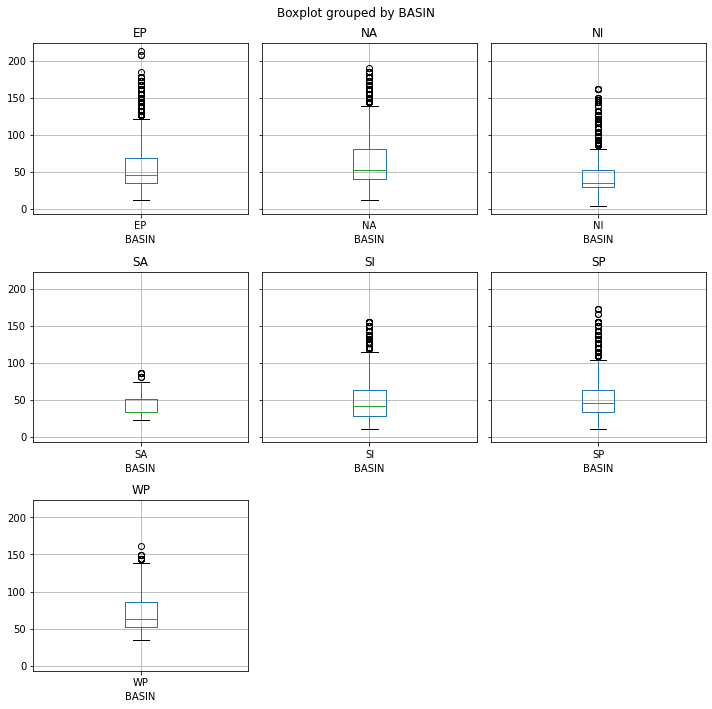

In [57]:
# (d.)
fix, ax = plt.subplots(figsize=(10,10))
#df.groupby('BASIN')['WMO_WIND'].describe().T.plot(kind='box', ax=ax)
df.groupby('BASIN').boxplot(column='WMO_WIND', by='BASIN', ax=ax)
plt.title('Basin Windspeed Distributions')
plt.tight_layout()

### (e.)
From these distributions, one can clearly see that while the vast majority of storms are on the weaker end of the spectrum,
outliers do frequently occur. These outliers are beyond the ~1.5*IOR range that the top whikers of the charts contain. These storms
can also be significantly more powerful than most of the distribution. In general the distribution tends towards weaker storms with
rare strong ones.

### (f.)
I find it likely that the differences in water temperature of each basin is the biggest contributor to the observed differences in hurricane strength when compared between basins.

### (6) In which basin, overall (i.e., over all seasons), were the most (unique) hurricanes observed - so, the greatest # of unique SID (the storm event ID)?

In [58]:
by_basin_unique = df.groupby('BASIN').nunique()
print(f'The basin with the most unique strorms is: {by_basin_unique["SID"].idxmax()}')

The basin with the most unique strorms is: WP


### (7) During which year, over all basins, were the most (unique) hurricanes observed - so, the greatest # of unique SID (the storm event ID)?
- *Optional challenge*: a plot of the number of unique hurricane events each year

In [59]:
by_year = df.groupby(df.date.dt.year).nunique()
print(f'The year with the most storms was: {by_year["SID"].idxmax()}')

The year with the most storms was: 1971


In [60]:
#TODO
#OPTIONAL STUFF

### (8) Finally, let's analyze some hurricane tracks!
### (a.) Create a map of all tracks of all hurricanes that occured in the North Atlantic basin in 2005, with the markers color-coded by *wind speed*. Please include coastlines, a colorbar, etc.
### (b.) *Interpretation*: For 2005 in the Atlantic Basin, in what geographic location(s) do the hurricanes tend to be the strongest? (*Optional*: Any guesses why?)

*Optional challenges*:
- highlight the track for Katrina specifically in some way (or, alternatively, just analyze the track of Katrina), and compare to what you produced in Week 9's Homework Assignment in whatever way you want! (Note: In Week 9's assignment, we used output from a *model simulation* of Katrina, this week we're using the "best-track", actual data for the track).

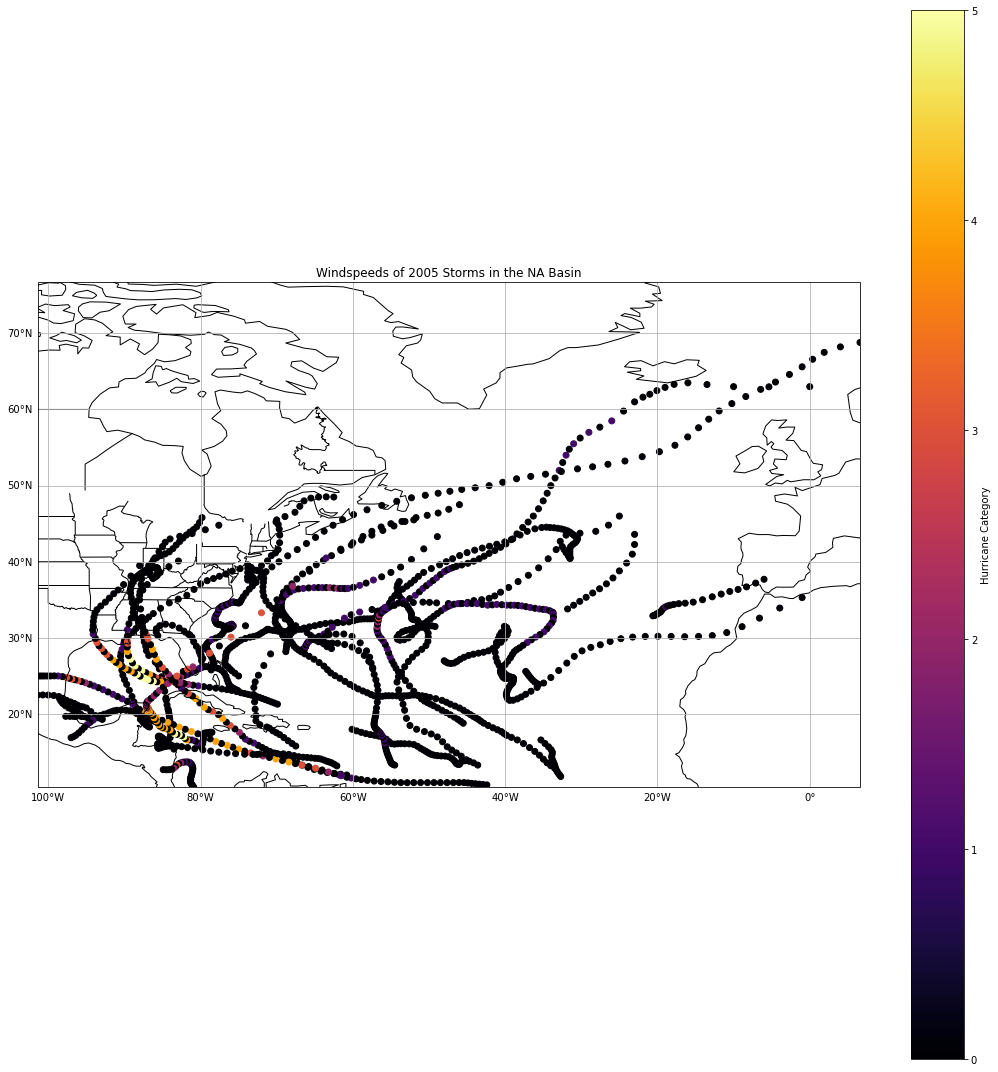

In [80]:
l_lim_cat1 = 74
l_lim_cat2 = 96
l_lim_cat3 = 111
l_lim_cat4 = 130
l_lim_cat5 = 157 # or greater

start_date = '2005-01-01'
end_date = '2005-12-31'
mask = (df['date'] > start_date) & (df['date'] <= end_date)
na_2005_data = df.loc[mask].where(df['BASIN'] == 'NA')

latmin = na_2005_data['LAT'].min()
latmax = na_2005_data['LAT'].max()
lonmin = na_2005_data['LON'].min()
lonmax = na_2005_data['LON'].max()
bounds = [ lonmin, lonmax, latmin, latmax ]


lon = na_2005_data['LON']
lat = na_2005_data['LAT']

def classifier(row):
    cat = 0
    if row['WMO_WIND'] < l_lim_cat1:
        cat = 0
    elif (row['WMO_WIND'] > l_lim_cat5): # Python can't optimize the branching, so make sure to break out with less compares for big N
        cat = 5
    elif (row['WMO_WIND'] >= l_lim_cat1) and (row['WMO_WIND'] < l_lim_cat2):
        cat = 1
    elif (row['WMO_WIND'] >= l_lim_cat2) and (row['WMO_WIND'] < l_lim_cat3):
        cat = 2
    elif (row['WMO_WIND'] >= l_lim_cat3) and (row['WMO_WIND'] < l_lim_cat4):
        cat = 3
    elif (row['WMO_WIND'] >= l_lim_cat4) and (row['WMO_WIND'] < l_lim_cat5):
        cat = 4
    return cat

na_2005_data['rank'] = na_2005_data.apply(classifier, axis=1)

X, Y = np.meshgrid(lon, lat)
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=proj))
cmap=plt.get_cmap('inferno')
ax.set_extent(bounds)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', 
                                            '50m', edgecolor='black', facecolor='none'))
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
sc = ax.scatter(lon, lat, cmap=cmap, c=na_2005_data['rank'])
cbar = plt.colorbar(sc)
cbar.set_label('Hurricane Category', rotation=90)
ax.set_title('Windspeeds of 2005 Storms in the NA Basin')
plt.tight_layout()

The strongest hurricanes appear to be concentrated around the Gulf of Mexico. I find it likely that this is due to the shallow, warm waters being more conducive to the development of high-intensity storms.